# Convergency checks

In [35]:
import sys
sys.path.append('../src/')

import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from utils.data_utils import load_data
from utils.plot_utils import set_plot_defaults
from utils.convergence_utils import check_mcse, check_neff, check_rhat

In [36]:
set_plot_defaults(font="Europace Sans")
d, zip_lookup, num_zip_codes = load_data()

target = "price_s"

In [6]:
data = az.from_netcdf("../models/centered_hier.nc")
data

Inference data with groups:
	> posterior
	> sample_stats
	> posterior_predictive
	> prior
	> observed_data

In [117]:
bad_data = az.from_netcdf("../models/bad_model.nc")

## Trace plots

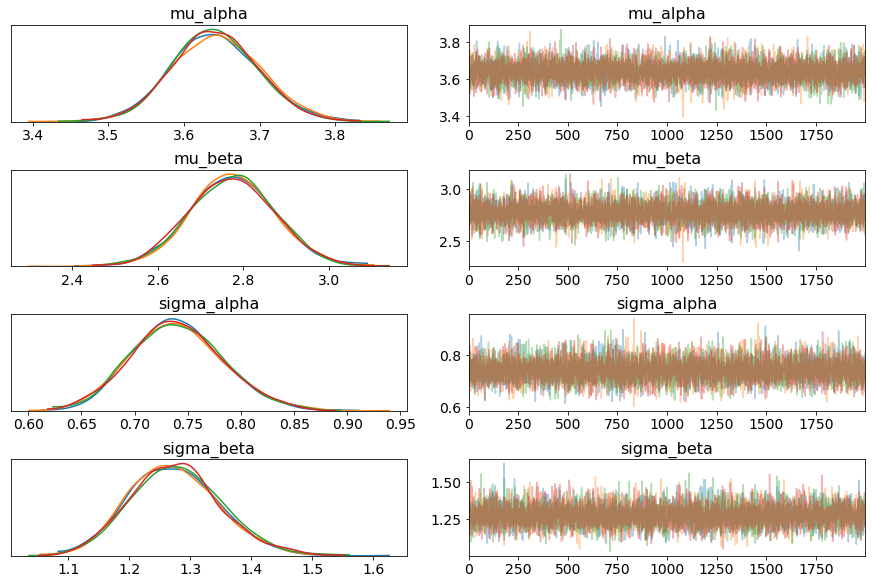

In [9]:
az.plot_trace(data, var_names=["mu_alpha", "mu_beta", "sigma_alpha", "sigma_beta"])
plt.show()

We actually have hundreds of parameter, we cannot feasibly plot all of them and look at all of them.

## Rhat
How much do the chains differ? Did all chains converge to the same distribution?

In [69]:
s = az.summary(data, round_to="none")
s.head()

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_alpha,3.640452,0.056331,3.534082,3.746163,0.000523,0.000370,11607.911393,11596.935408,11627.610224,6477.969543,1.000913
mu_beta,2.773088,0.098341,2.583392,2.952781,0.000920,0.000652,11421.304556,11381.095227,11445.935320,6369.734210,1.000899
alpha[0],4.977053,0.163904,4.675607,5.286384,0.001447,0.001024,12831.248371,12817.407143,12852.777554,6409.564152,1.000381
alpha[1],5.098820,0.286901,4.547133,5.625792,0.002563,0.001818,12533.563339,12448.926994,12535.095101,6472.901624,1.000199
alpha[2],5.130201,0.199719,4.773733,5.516921,0.001681,0.001188,14124.843376,14124.843376,14126.574365,6121.937282,1.000489


In [129]:
data.posterior

<xarray.Dataset>
Dimensions:      (chain: 4, draw: 2000, zip_code: 219)
Coordinates:
  * chain        (chain) int64 0 1 2 3
  * draw         (draw) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * zip_code     (zip_code) object '10115' '10117' '10119' ... '14621' '14641'
Data variables:
    mu_alpha     (chain, draw) float64 3.65 3.665 3.675 ... 3.654 3.717 3.653
    mu_beta      (chain, draw) float64 2.82 2.744 2.781 ... 2.729 2.947 2.88
    alpha        (chain, draw, zip_code) float64 5.052 4.906 ... 2.961 3.462
    beta         (chain, draw, zip_code) float64 3.37 3.251 ... 2.673 -0.1038
    sigma_alpha  (chain, draw) float64 0.7229 0.6952 0.6968 ... 0.702 0.749
    sigma_beta   (chain, draw) float64 1.191 1.205 1.208 ... 1.196 1.269 1.155
    sigma        (chain, draw) float64 1.205 1.21 1.21 ... 1.211 1.197 1.196
Attributes:
    created_at:                 2019-09-30T16:51:30.073288
    inference_library:          pymc3
    inference_library_version:  3.7

In [ ]:
data.posterior

The following parameters have an Rhat greater 1.003:
['beta[93]', 'beta[94]']



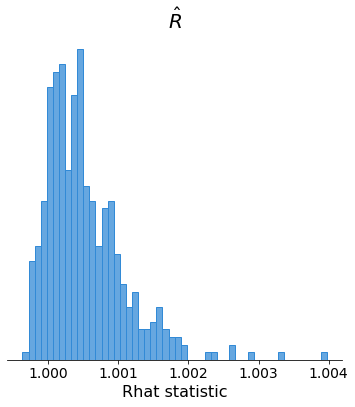

In [100]:
check_rhat(data, threshold=1.003)
plt.show()

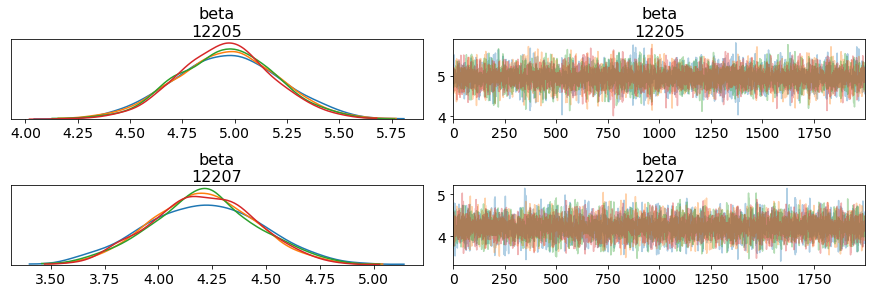

In [115]:
az.plot_trace(data, var_names=['beta'], coords={"zip_code": [zip_codes[93], zip_codes[94]]})
plt.show()

The following parameters have an Rhat greater 1.02:
['alpha[54]', 'alpha[86]', 'alpha[119]', 'beta[60]', 'beta[215]', 'sigma[60]', 'sigma[62]', 'sigma[188]']



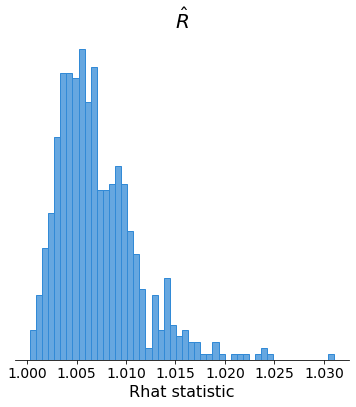

In [119]:
check_rhat(bad_data, threshold=1.01)
plt.show()

The following parameters have an effective sample size less than 10.0% of the total sample size:
['alpha[6]', 'alpha[10]', 'alpha[14]', 'alpha[24]', 'alpha[46]', 'alpha[54]', 'alpha[57]', 'alpha[66]', 'alpha[71]', 'alpha[75]', 'alpha[119]', 'alpha[121]', 'alpha[128]', 'alpha[129]', 'alpha[160]', 'alpha[164]', 'alpha[187]', 'alpha[198]', 'alpha[202]', 'alpha[211]', 'beta[13]', 'beta[32]', 'beta[41]', 'beta[42]', 'beta[54]', 'beta[60]', 'beta[63]', 'beta[86]', 'beta[102]', 'beta[114]', 'beta[126]', 'beta[134]', 'beta[145]', 'beta[160]', 'beta[161]', 'beta[176]', 'beta[202]', 'beta[215]', 'sigma[0]', 'sigma[6]', 'sigma[36]', 'sigma[57]', 'sigma[60]', 'sigma[75]', 'sigma[86]', 'sigma[93]', 'sigma[94]', 'sigma[107]', 'sigma[117]', 'sigma[128]', 'sigma[142]', 'sigma[155]', 'sigma[163]', 'sigma[188]', 'sigma[193]', 'sigma[197]', 'sigma[217]']



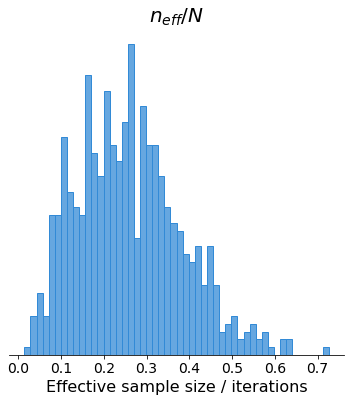

In [124]:
check_neff(bad_data)
plt.show()

In [49]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample(tune=50, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 1100/1100 [00:03<00:00, 356.81draws/s]
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
There were 66 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.43590577761253674, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


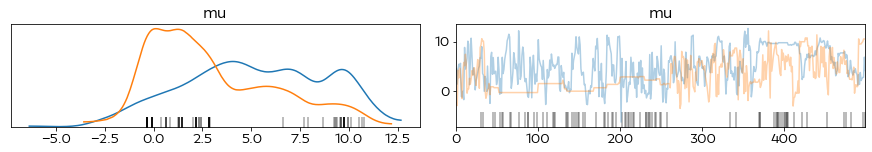

In [51]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

In [78]:
# Data of the Eight Schools Model
J = 8
y = np.array([28.,  8., -3.,  7., -1.,  1., 18., 12.])
sigma = np.array([15., 10., 16., 11.,  9., 11., 10., 18.])
# tau = 25.
with pm.Model() as Centered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta = pm.Normal('theta', mu=mu, sigma=tau, shape=J)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample(tune=500, draws=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta, tau, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:03<00:00, 640.35draws/s]
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6475825364814808, but should be close to 0.8. Try to increase the number of tuning steps.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.576665814410612, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


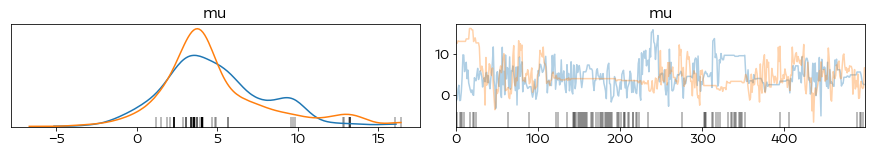

In [79]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

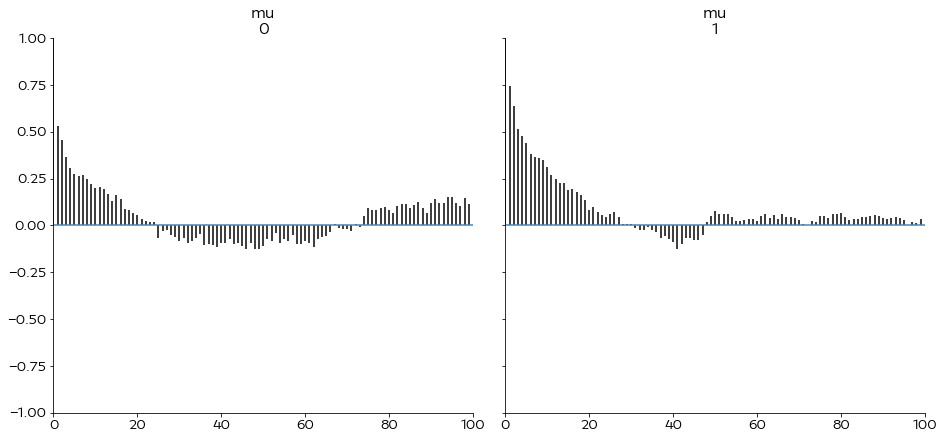

In [91]:
axes = az.plot_autocorr(posterior, var_names=["mu"], figsize=(13,6))
for axe in axes:
    for ax in axe:
        ax.spines["top"].set_visible(False)  
        ax.spines["right"].set_visible(False)
plt.show()

In [74]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sigma=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_t, tau, mu]
Sampling 2 chains: 100%|██████████| 2000/2000 [00:02<00:00, 975.16draws/s] 


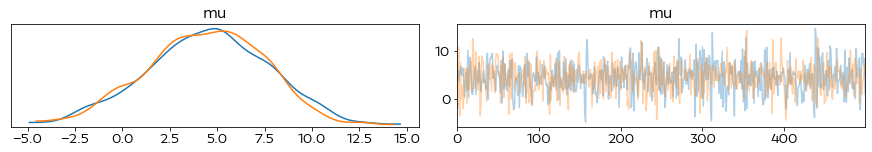

In [75]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

In [72]:
with pm.Model() as NonCentered_eight:
    mu = pm.Normal('mu', mu=0, sigma=5)
    tau = pm.HalfCauchy('tau', beta=5)
    theta_tilde = pm.Normal('theta_t', mu=0, sigma=1, shape=J)
    theta = pm.Deterministic('theta', mu + tau * theta_tilde)
    obs = pm.Normal('obs', mu=theta, sigma=sigma, observed=y)
    posterior = pm.sample(tune=1000, draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta_t, tau, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1010.41draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


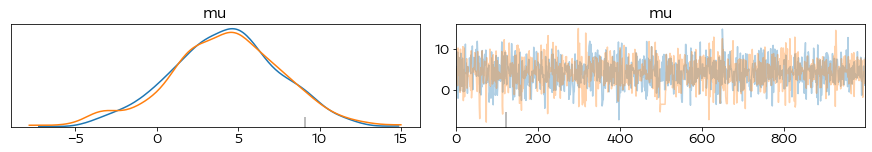

In [73]:
az.plot_trace(posterior, var_names=["mu"])
plt.show()

In [44]:
az.rhat(posterior)

<xarray.Dataset>
Dimensions:      (theta_dim_0: 8)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 0 1 2 3 4 5 6 7
Data variables:
    mu           float64 1.024
    theta        (theta_dim_0) float64 1.015 1.014 1.013 ... 1.007 1.017 1.008
    tau          float64 1.008

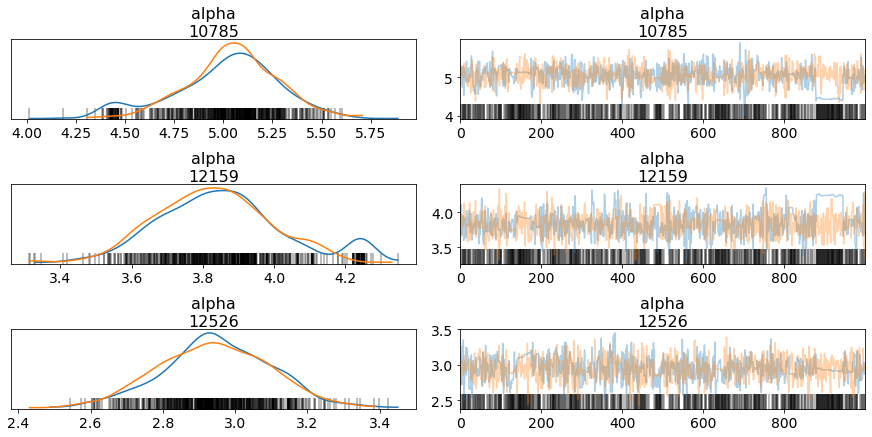

In [126]:
az.plot_trace(bad_data, var_names=['alpha'], coords={"zip_code": [zip_codes[54], zip_codes[86],
                                                             zip_codes[119]],
                                                    "chain": [0,1]})
plt.show()

The following parameters have an effective sample size less than 10.0% of the total sample size:
None



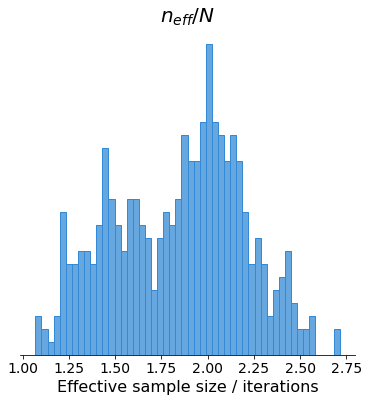

In [101]:
check_neff(data)
plt.show()

The following parameters have a Monte Carlo standard error greater than 10.0% of the posterior standard deviation:
None



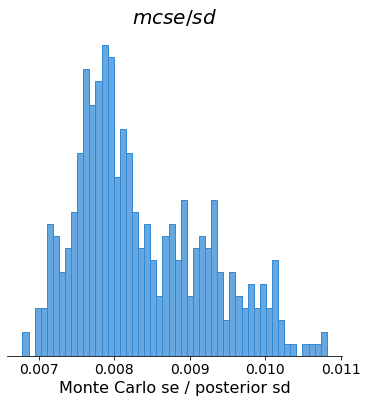

In [106]:
check_mcse(data)
plt.show()